# Traditional Model

In [1]:
import os
os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from numpy.random import randn
from math import radians, sin, cos, sqrt, asin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [3]:
from data_pipeline import Pipeline

In [4]:
df = pd.read_csv('data/CreditCardFraudFourYears.csv')

In [5]:
pipeline = Pipeline()
transformed_df = pipeline.transform(df)

In [6]:
for column in transformed_df.columns:
    if pd.api.types.is_bool_dtype(transformed_df[column]):
        transformed_df[column] = transformed_df[column].astype(int)
    if pd.api.types.is_integer_dtype(transformed_df[column]):
        transformed_df[column] = transformed_df[column].astype(float)
transformed_df.dtypes

total_daily_transactions          float64
total_daily_fraud_transactions    float64
hour_0                            float64
hour_1                            float64
hour_2                            float64
hour_3                            float64
hour_4                            float64
hour_5                            float64
hour_6                            float64
hour_7                            float64
hour_8                            float64
hour_9                            float64
hour_10                           float64
hour_11                           float64
hour_12                           float64
hour_13                           float64
hour_14                           float64
hour_15                           float64
hour_16                           float64
hour_17                           float64
hour_18                           float64
hour_19                           float64
hour_20                           float64
hour_21                           

In [8]:
split_idx = int(len(transformed_df) * 0.8)

split_date = transformed_df.index[split_idx]
print(split_date)

2021-12-31 00:00:00


In [10]:
from sklearn.model_selection import train_test_split

train = transformed_df.loc[transformed_df.index <= split_date]
test = transformed_df.loc[transformed_df.index > split_date]

train_info = (train.index.min(), train.index.max(), len(train))
test_info = (test.index.min(), test.index.max(), len(test))

print(train_info, test_info)

print(f'Training set range: {train.index.min()} to {train.index.max()}')
print(f'Test set range: {test.index.min()} to {test.index.max()}')
print(f'Training set size: {len(train)}')
print(f'Test set size: {len(test)}')

(Timestamp('2018-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'), 1461) (Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'), 365)
Training set range: 2018-01-01 00:00:00 to 2021-12-31 00:00:00
Test set range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Training set size: 1461
Test set size: 365


In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['total_daily_fraud_transactions'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -18.271246
p-value: 0.000000


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 0,0,1 
P, D, Q, m = 0,0,0,365

exog_data = transformed_df[['total_daily_transactions', 'hour_0', 
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'is_public_holiday',
       'is_payday', 'day_of_week', 'month','weekday_vs_weekend']]
        

model = SARIMAX(train['total_daily_fraud_transactions'],
                exog=train[exog_data.columns],
                order=(p, d, q),
                seasonal_order=(P, D, Q, m))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:     total_daily_fraud_transactions   No. Observations:                 1461
Model:                           SARIMAX(0, 0, 1)   Log Likelihood               -4376.542
Date:                            Fri, 05 Apr 2024   AIC                           8819.084
Time:                                    18:25:51   BIC                           8993.551
Sample:                                01-01-2018   HQIC                          8884.165
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_daily_transactions    -0.0046      0.000    -16.270      0.000      -0.005      

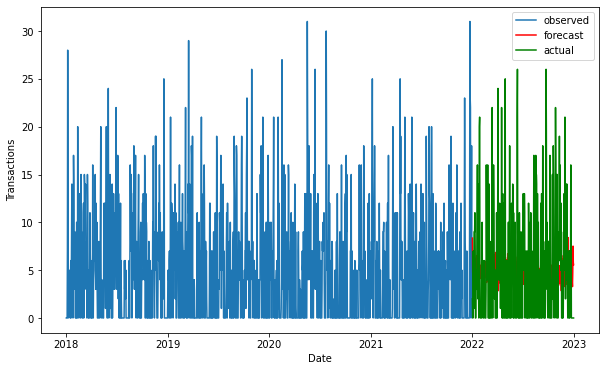

In [34]:
forecast = results.get_forecast(steps=365, exog=test[exog_data.columns])
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train['total_daily_fraud_transactions'].index.to_pydatetime(), train['total_daily_fraud_transactions'].values, label='observed')

plt.plot(mean_forecast.index.to_pydatetime(), mean_forecast.values, color='r', label='forecast')

plt.plot(test['total_daily_fraud_transactions'].index.to_pydatetime(), test['total_daily_fraud_transactions'].values, color='g', label='actual')

plt.xlabel('Date')
plt.ylabel('Transactions')
plt.legend()
plt.show()